In [5]:
#Upload libraries
import locale
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import seaborn as sns #plots
import numpy as np
import statistics as stats # statistics
import matplotlib.pyplot as plt #graphs
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [6]:
#Upload data with pandas
df = pd.read_csv("9 VAR_M1_2-1.csv", encoding="latin-1", delimiter=";")
df.head(10)

,date,inflation,M1
0,2001-01-01 00:00:00,48.575476,"524,836,129.99"
1,2001-02-01 00:00:00,48.543328,"517,186,605.97"
2,2001-03-01 00:00:00,48.850888,"509,701,873.04"
3,2001-04-01 00:00:00,49.097309,"511,952,430.01"
4,2001-05-01 00:00:00,49.209970,"514,845,459.96"
5,2001-06-01 00:00:00,49.326364,"531,037,690.04"
6,2001-07-01 00:00:00,49.198202,"535,590,658.99"
7,2001-08-01 00:00:00,49.489688,"546,637,481.95"
8,2001-09-01 00:00:00,49.950381,"578,773,946.96"
9,2001-10-01 00:00:00,50.176135,"577,395,499.96"


Declare time serie

In [7]:
#Create a security copy
df1=df.copy()

In [8]:
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Remove commas from 'M1' column and convert it to a float
df['M1'] = df['M1'].str.replace(',', '').astype(float)

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Now df is a time series DataFrame
df.head()

,inflation,M1
date,,
2001-01-01,48.575476,5.248361e+08
2001-02-01,48.543328,5.171866e+08
2001-03-01,48.850888,5.097019e+08
2001-04-01,49.097309,5.119524e+08
2001-05-01,49.209970,5.148455e+08


**1) EXAMINE DATA AND CLEAN DATAFRAME**

In [9]:
df.info()
#M1= Monetary aggregate (bills, coins and bank deposits)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2001-01-01 to 2024-05-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inflation  281 non-null    float64
 1   M1         281 non-null    float64
dtypes: float64(2)
memory usage: 6.6 KB


In [10]:
#Let's see null data
df.isnull().sum()

inflation    0
M1           0
dtype: int64

In [11]:
# Let's see if there are duplicated rows
duplicated_rows = df.duplicated()
# show me the duplicated rows
print("Filas duplicadas:")
print(df[duplicated_rows])


Filas duplicadas:
Empty DataFrame
Columns: [inflation, M1]
Index: []


In [12]:
# Duplicated rows
num_duplicated = duplicated_rows.sum()
print(f"Número de filas duplicadas: {num_duplicated}")

Número de filas duplicadas: 0


Exploratory analyisis

In [13]:
#Basic statistics
df_descriptive_stats = df.describe()

# Descriptive statistics
df_descriptive_stats.round(1)

,inflation,M1
count,281.0,2.810000e+02
mean,82.7,2.783049e+09
std,23.5,2.008696e+09
min,48.5,5.097019e+08
25%,62.3,1.117490e+09
50%,79.4,2.081526e+09
75%,99.9,4.197524e+09
max,134.3,7.445689e+09


PLOT TIME SERIES

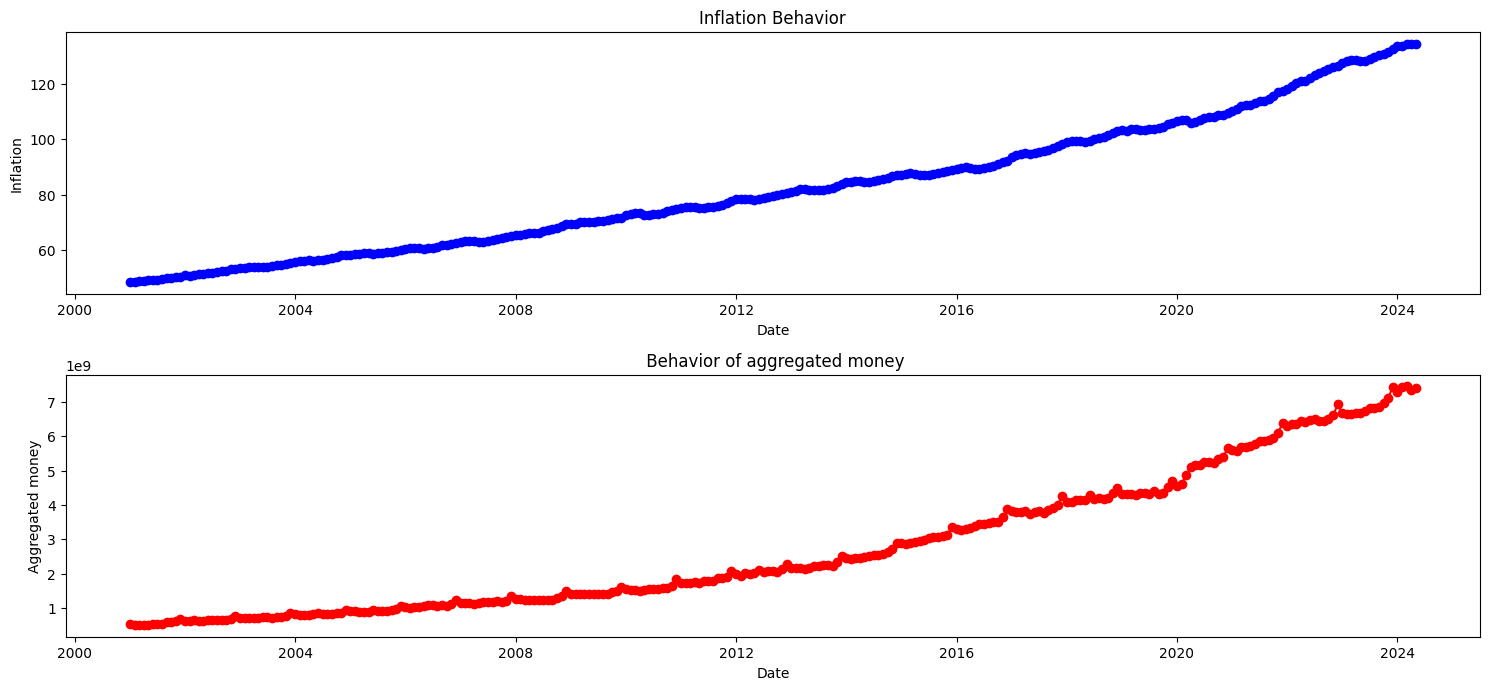

In [14]:
#Plot variables
plt.figure(figsize=(15, 10))

# Inflation
plt.subplot(3, 1, 1)
plt.plot(df.index, df['inflation'], marker='o', linestyle='-', color='b')
plt.title('Inflation Behavior')
plt.xlabel('Date')
plt.ylabel('Inflation')

# M1 (monetary aggregate )
plt.subplot(3, 1, 2)
plt.plot(df.index, df['M1'], marker='o', linestyle='-', color='r')
plt.title(' Behavior of aggregated money')
plt.xlabel('Date')
plt.ylabel('Aggregated money')


plt.tight_layout()
plt.show()

**2) CHECK FOR STATIONARITY:** Apply Augmented Dickey Fuller Test
In the ADF test:

Ho: Time Series is considered non-stationary

**Ha: Time series is stationary when p-value of the test <0.05**

In [15]:
#Let's create a function to apply the ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # .dropna() handles differenced data
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())  # .to_string() removes the line "dtype: float64"


In [16]:
# Perform the ADF test on each column. It is stationary if p-value< 0.05 :-)
adf_test(df['inflation'], title='Inflation Data')
adf_test(df['M1'], title='Aggregated money')


Augmented Dickey-Fuller Test: Inflation Data
ADF test statistic        1.932498
p-value                   0.998579
# lags used              12.000000
# observations          268.000000
critical value (1%)      -3.454988
critical value (5%)      -2.872386
critical value (10%)     -2.572549
Augmented Dickey-Fuller Test: Aggregated money
ADF test statistic        3.461943
p-value                   1.000000
# lags used              15.000000
# observations          265.000000
critical value (1%)      -3.455270
critical value (5%)      -2.872509
critical value (10%)     -2.572615


We can see that 2 variables have a unit root and are "non stationary", since all "p-values" are > than 0.05 :-(

P_values: inflation 0.99  

M1: 1.000

**3) CHECK NUMBER OF NEEDED DIFFERENCES** to apply in the VAR

In [17]:
# Function to find the number of differences necessary to make the series stationary (maximum 5)
def find_differencing(series, max_diff=5):
    diff = 0
    current_series = series.copy()

    while not adf_test(current_series) and diff < max_diff:
        if len(current_series) <= 1:
            print("La serie es demasiado corta para más diferenciaciones.")
            return diff
        diff += 1
        current_series = current_series.diff().dropna()
        print(f"Diferenciación {diff} para la columna actual: ADF p-value = {adfuller(current_series)[1]}")

    return diff

In [18]:
# Calculate the number of differences needed for each column (maximum 5)
# Inflation need 2 differences:  p-value = 4.927121886088865e-25 = 0.0000000000000000000000004927121886088865 < 0.05
#M1 needs 2 differences: 7.219910748906208e-10=0.0000000007219910748906208 < 0.05


resultados_diferenciacion = {}
for columna in df.columns:
    print(f"\nAnalizando la columna {columna}...")
    num_diff = find_differencing(df[columna], max_diff=5)
    resultados_diferenciacion[columna] = num_diff




Analizando la columna inflation...
Augmented Dickey-Fuller Test: 
ADF test statistic        1.932498
p-value                   0.998579
# lags used              12.000000
# observations          268.000000
critical value (1%)      -3.454988
critical value (5%)      -2.872386
critical value (10%)     -2.572549
Diferenciación 1 para la columna actual: ADF p-value = 0.37898714339307327
Augmented Dickey-Fuller Test: 
ADF test statistic       -1.802972
p-value                   0.378987
# lags used              11.000000
# observations          268.000000
critical value (1%)      -3.454988
critical value (5%)      -2.872386
critical value (10%)     -2.572549
Diferenciación 2 para la columna actual: ADF p-value = 4.927121886089115e-25
Augmented Dickey-Fuller Test: 
ADF test statistic     -1.338339e+01
p-value                 4.927122e-25
# lags used             1.000000e+01
# observations          2.680000e+02
critical value (1%)    -3.454988e+00
critical value (5%)    -2.872386e+00
critica

 Inflation needs 2 differences:

M1 needs 2 differences:

**Apply differenciation and prepare data for modeling**

 Differencing is a common technique used to remove trends and make the data stationary.

 We will only difference "inflation and enemply" to make it stationary.

In [19]:
# Columns that need differentiation and the number of differences required
columns_to_diff = {'inflation': 2, 'M1': 2}
# Columns that do not need differentiation
columns_no_diff = []

# Apply differentiation to selected columns
df_diff = df.copy()
for col, n_diffs in columns_to_diff.items():
    for _ in range(n_diffs):
        df_diff[col] = df_diff[col].diff()
df_diff = df_diff.dropna()

# Ensure all columns are aligned (here we just use an empty list as no columns are undifferentiated)
if columns_no_diff:
    df_non_diff = df[columns_no_diff].iloc[max(columns_to_diff.values()):]
    # Combine differentiated and non-differentiated columns
    df_combined = pd.concat([df_diff[columns_to_diff.keys()], df_non_diff], axis=1).dropna()
else:
    df_combined = df_diff[columns_to_diff.keys()]

print("Combined Data (Differenced where needed):")
print(df_combined.head())

Combined Data (Differenced where needed):
            inflation           M1
date                              
2001-03-01   0.339708    164791.09
2001-04-01  -0.061139   9735289.90
2001-05-01  -0.133759    642472.98
2001-06-01   0.003731  13299200.13
2001-07-01  -0.244555 -11639261.13


**3) TRAIN TEST SPLIT**

In [20]:
# Train-Test Split
#Split the differenced data into training and testing sets, using the last 12 observations (assuming Monthly data) for testing.

test_obs = 12

train = df_combined[:-test_obs]
test = df_combined[-test_obs:]

print("Train set:")
print(train.tail())
print("Test set:")
print(test.head())

Train set:
            inflation            M1
date                               
2023-01-01      0.377 -5.793123e+08
2023-02-01     -0.148  2.252992e+08
2023-03-01     -0.367  4.132605e+07
2023-04-01     -0.369  1.305685e+07
2023-05-01     -0.253 -1.925362e+07
Test set:
            inflation           M1
date                              
2023-06-01      0.409  57427562.14
2023-07-01      0.488   7181979.42
2023-08-01      0.095 -68073465.26
2023-09-01     -0.138  37569720.34
2023-10-01     -0.086  64451204.21


4) **GRID SEARCH FOR LAG ORDER P**

In [21]:
#  Grid Search for Optimal Lag Order.
# VERY IMPORTANT: The lag order determines how many past observations (lags) of the variables are used to predict the current value of the variables.
# We have to determine the optimal lag order based on AIC and BIC
#The best AIC and BIC are those with the lowest results.

aic_values = []
bic_values = []
for i in range(1, 11):  # the more lags, the more complex is the model, We choose until 11, but we select more lags
    model = VAR(train)
    results = model.fit(i)
    aic_values.append(results.aic)
    bic_values.append(results.bic)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Order = 1
AIC:  34.338332440487335
BIC:  34.41916318429444

Order = 2
AIC:  34.08636613093458
BIC:  34.22145027531142

Order = 3
AIC:  33.993648687927674
BIC:  34.18328235248846

Order = 4
AIC:  33.7466111653409
BIC:  33.99109319035687

Order = 5
AIC:  33.52156187538682
BIC:  33.82119385661867

Order = 6
AIC:  33.270644812003844
BIC:  33.62573113610495

Order = 7
AIC:  33.15332608945973
BIC:  33.56417396996152

Order = 8
AIC:  33.068740513093665
BIC:  33.53566002698472

Order = 9
AIC:  33.03191897065122
BIC:  33.555223095562155

Order = 10
AIC:  32.98105256813007
BIC:  33.56105722013629



c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Administrador\A

In [22]:
# Find the optimal lag order based on AIC and BIC
#Once the optimal lag order P is determined, it is used to specify how many past values of each variable should be included in the VAR model.
optimal_order_aic = np.argmin(aic_values) + 1
optimal_order_bic = np.argmin(bic_values) + 1

print(f'Optimal order based on AIC: {optimal_order_aic}')
print(f'Optimal order based on BIC: {optimal_order_bic}')

Optimal order based on AIC: 10
Optimal order based on BIC: 8


**5) APPLY VAR MODEL WITH ORDER P**

Let's try with 10 laggs- AIC/BIC

In [23]:
model = VAR(train)
optimal_order = model.select_order(maxlags=10).aic
results2 = model.fit(optimal_order)
results2.summary()

c:\Users\Administrador\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 16, Jul, 2024
Time:                     12:08:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    33.5611
Nobs:                     257.000    HQIC:                   33.2143
Log likelihood:          -4925.40    FPE:                2.10769e+14
AIC:                      32.9811    Det(Omega_mle):     1.80129e+14
--------------------------------------------------------------------
Results for equation inflation
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.006281         0.013519            0.465           0.642
L1.inflation         -0.541453         0.063586           -8.515           0.000
L1.M1                 0.000000         0.000000         

**In inflation equation**





**6) FORECAST**:

There are in differences (2)

In [24]:
lagged_Values = train.values[-10:] #lags
pred = results2.forecast(y=lagged_Values, steps=12)

idx = pd.date_range('2024-06-01', periods=12, freq='MS')
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['inflation', 'M1'])

In [25]:
df_forecast

,inflation,M1
2024-06-01,0.935307,7.247019e+07
2024-07-01,0.005083,-6.353725e+07
2024-08-01,-0.109863,-3.553326e+07
2024-09-01,0.243798,3.063550e+07
2024-10-01,-0.090097,1.151524e+06
2024-11-01,0.227518,8.099331e+07
2024-12-01,-0.550003,2.684896e+07
2025-01-01,0.171277,-1.850627e+08
2025-02-01,-0.059628,4.723647e+07
2025-03-01,-0.103654,5.405478e+07


**7) Invert the transformation**

We have to note that the forecasted values (Inflation and M1) are  differenced in order  2 . To get it similar to original data we have to roll back each difference.

In [26]:
# Forecast future values (June 2024 to May 2025)
if len(train) >= optimal_order:
    # Get the last 'optimal_order' values for forecasting
    lagged_values = train.values[-optimal_order:]
    pred = results.forecast(y=lagged_values, steps=12)

    # Create new index for the forecast period
    idx = pd.date_range(start='2024-06-01', periods=12, freq='MS')
    forecast_df = pd.DataFrame(data=pred, index=idx, columns=train.columns)

    # Revert the second differencing to get the forecast in first differences
    for col in columns_to_diff:
        forecast_df[col] = forecast_df[col].cumsum()

    # Get the last known first difference values
    last_diff = df_diff.iloc[-1]
    for col in columns_to_diff:
        forecast_df[col] = last_diff[col] + forecast_df[col].cumsum()

    # Get the last known original values
    last_original = df.iloc[-1]
    for col in columns_to_diff:
        forecast_df[col] = last_original[col] + forecast_df[col]

    print("Forecasted values for June 2024 to May 2025:")
    print(forecast_df)

Forecasted values for June 2024 to May 2025:
             inflation            M1
2024-06-01  134.502307  7.645883e+09
2024-07-01  135.442697  7.654816e+09
2024-08-01  136.273223  7.628216e+09
2024-09-01  137.347548  7.632251e+09
2024-10-01  138.331774  7.637437e+09
2024-11-01  139.543519  7.723617e+09
2024-12-01  140.205262  7.836646e+09
2025-01-01  141.038281  7.764613e+09
2025-02-01  141.811673  7.739815e+09
2025-03-01  142.481410  7.769073e+09
2025-04-01  142.980102  7.745072e+09
2025-05-01  143.456863  7.751350e+09


PLOT

In [27]:
# Combine historical and forecast data
combined_df = pd.concat([df, forecast_df])
print("Combined Data (Historical + Forecasted):")
combined_df.tail(25)


Combined Data (Historical + Forecasted):


,inflation,M1
2023-05-01,128.084000,6.679351e+09
2023-06-01,128.214000,6.741457e+09
2023-07-01,128.832000,6.810745e+09
2023-08-01,129.545000,6.811960e+09
2023-09-01,130.120000,6.850744e+09
2023-10-01,130.609000,6.953980e+09
2023-11-01,131.445000,7.109145e+09
2023-12-01,132.373000,7.442319e+09
2024-01-01,133.555000,7.281862e+09
2024-02-01,133.681000,7.422935e+09


Plot

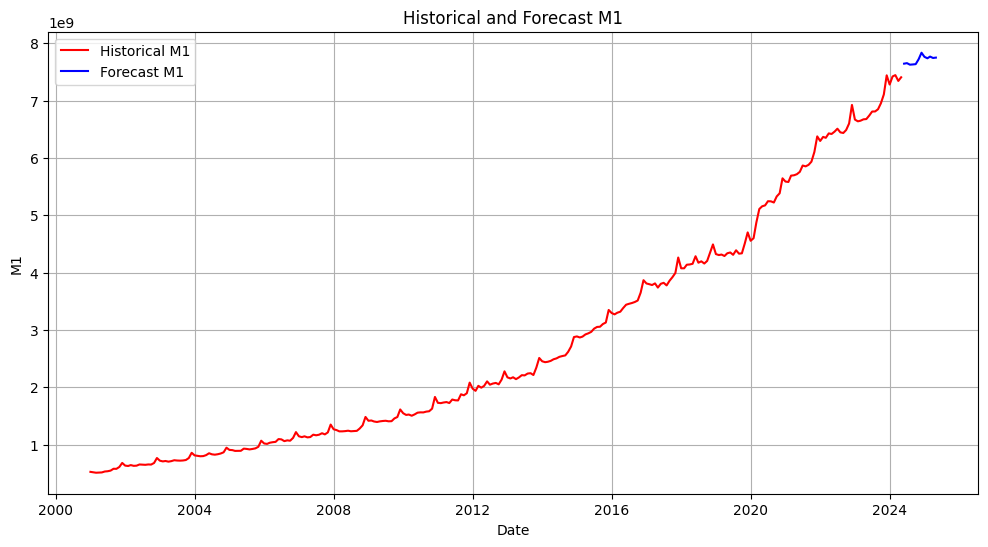

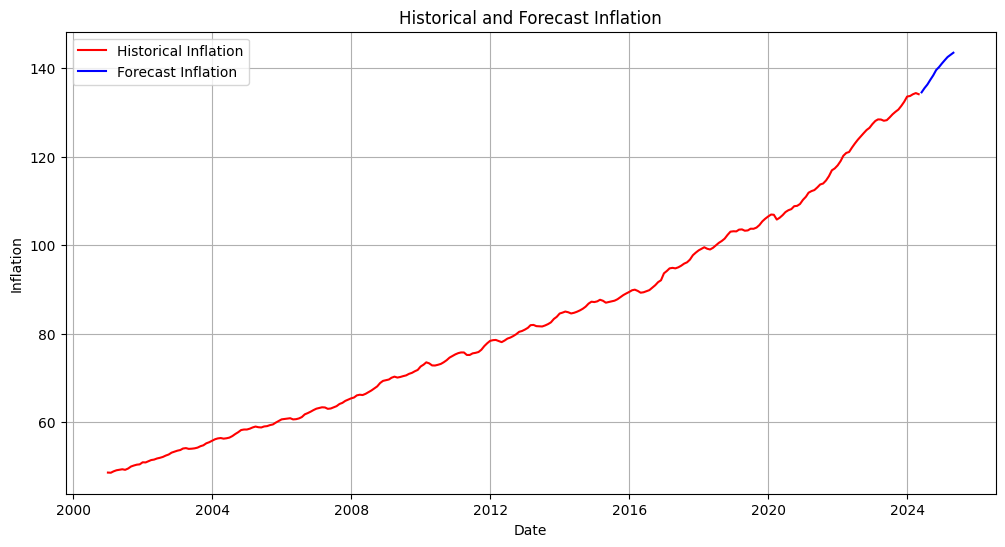

In [28]:
# Plot M1 data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['M1'], color='red', label='Historical M1') #HISTORICAL DATA
plt.plot(forecast_df.index, forecast_df['M1'], color='blue', label='Forecast M1') #FORECAST
plt.xlabel('Date')
plt.ylabel('M1')
plt.title('Historical and Forecast M1')
plt.legend()
plt.grid(True)
plt.show()

# Plot inflation data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['inflation'], color='red', label='Historical Inflation') #HISTORICAL DATA
plt.plot(forecast_df.index, forecast_df['inflation'], color='blue', label='Forecast Inflation') #FORECAST DATA
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.title('Historical and Forecast Inflation')
plt.legend()
plt.grid(True)
plt.show()